In [1]:
import functools
import numpy as np
import sympy
import matplotlib.pyplot as plt
import keras
import keras.backend as K
sympy.init_printing()

/home/marco/.virtualenvs/ml/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


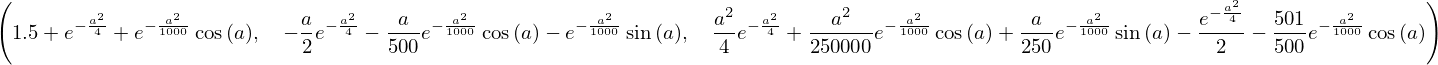

In [63]:
a = sympy.symbols('a')
iF = sympy.cos(a) * sympy.exp(-a**2/1000) + sympy.exp(-a**2/4) + 1.5
F = iF.diff(a)
dF = F.diff(a)
lambda_iF = sympy.lambdify((a,), iF)
lambda_F = sympy.lambdify((a,), F)
lambda_dF = sympy.lambdify((a,), dF)
iF, F, dF

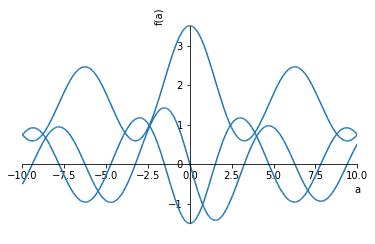

In [43]:
sympy.plot(iF, F, dF)
plt.show()

In [44]:
xtrain = (np.random.random((100000,1)) - 0.5) * 20
xtest = (np.random.random((10000,1)) - 0.5) * 20
ytrain, ytest = lambda_F(xtrain), lambda_F(xtest)

In [45]:
def build_nn_pair():
    X = X_input = keras.layers.Input((1,))
    X = keras.layers.BatchNormalization()(X)
    X = keras.layers.Dense(32, activation='tanh')(X)
    X = keras.layers.Dense(32, activation='tanh')(X)
    X = keras.layers.Dense(32, activation='tanh')(X)
    X = keras.layers.Dense(32, activation='tanh')(X)
    X = keras.layers.Dense(1)(X)
    M_Integral = keras.Model(X_input, X)
    M_Integral.compile('nadam', 'mse', ['mae'])
    X = M_Integral(X_input)
    X = keras.layers.Lambda(
        lambda x: K.gradients(x[1], x[0])[0] + K.sum(x[1])*0,
        output_shape=(1,))([X_input, X])
    M_DIntegral = keras.Model(X_input, X)
    M_DIntegral.compile('nadam', 'mse', ['mae'])
    return M_Integral, M_DIntegral

In [54]:
M_Integral, M_DIntegral = build_nn_pair()
M_IDerivative, M_Derivative = build_nn_pair()
X = X_input = keras.layers.Input((1,))
X_DI = M_DIntegral(X_input)
X_ID = M_IDerivative(X_input)
X_add = keras.layers.Lambda(lambda x: sum(x) / 2)([X_DI, X_ID])
X_sub = keras.layers.Lambda(lambda x: (x[1] - x[0]) / 2)([X_DI, X_ID])
X_sub = keras.layers.ActivityRegularization(l2=0.01)(X_sub)
X = keras.layers.Add()([X_add, X_sub])
M = keras.Model(X_input, X)
M.compile('nadam', 'mse', ['mae'])
M.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_33 (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
model_54 (Model)                (None, 1)            3269        input_33[0][0]                   
__________________________________________________________________________________________________
model_55 (Model)                (None, 1)            3269        input_33[0][0]                   
__________________________________________________________________________________________________
lambda_40 (Lambda)              (None, 1)            0           model_54[1][0]                   
                                                                 model_55[2][0]                   
__________

In [55]:
M.fit(xtrain, ytrain, validation_data=(xtest, ytest), batch_size=256, epochs=50, callbacks=[
    keras.callbacks.ReduceLROnPlateau(patience=5, verbose=1),
    keras.callbacks.EarlyStopping(patience=10),
])

Train on 100000 samples, validate on 10000 samples
Epoch 1/50
100000/100000 [==============================] - 6s 55us/step - loss: 0.5970 - mean_absolute_error: 0.6701 - val_loss: 0.5995 - val_mean_absolute_error: 0.6732
Epoch 2/50
100000/100000 [==============================] - 3s 33us/step - loss: 0.5958 - mean_absolute_error: 0.6695 - val_loss: 0.6016 - val_mean_absolute_error: 0.6722
Epoch 3/50
100000/100000 [==============================] - 3s 33us/step - loss: 0.5954 - mean_absolute_error: 0.6691 - val_loss: 0.6024 - val_mean_absolute_error: 0.6712
Epoch 4/50
100000/100000 [==============================] - 3s 33us/step - loss: 0.5952 - mean_absolute_error: 0.6688 - val_loss: 0.6078 - val_mean_absolute_error: 0.6686
Epoch 5/50
100000/100000 [==============================] - 3s 33us/step - loss: 0.5950 - mean_absolute_error: 0.6684 - val_loss: 0.6039 - val_mean_absolute_error: 0.6679
Epoch 6/50
100000/100000 [==============================] - 3s 33us/step - loss: 0.4616 - mean

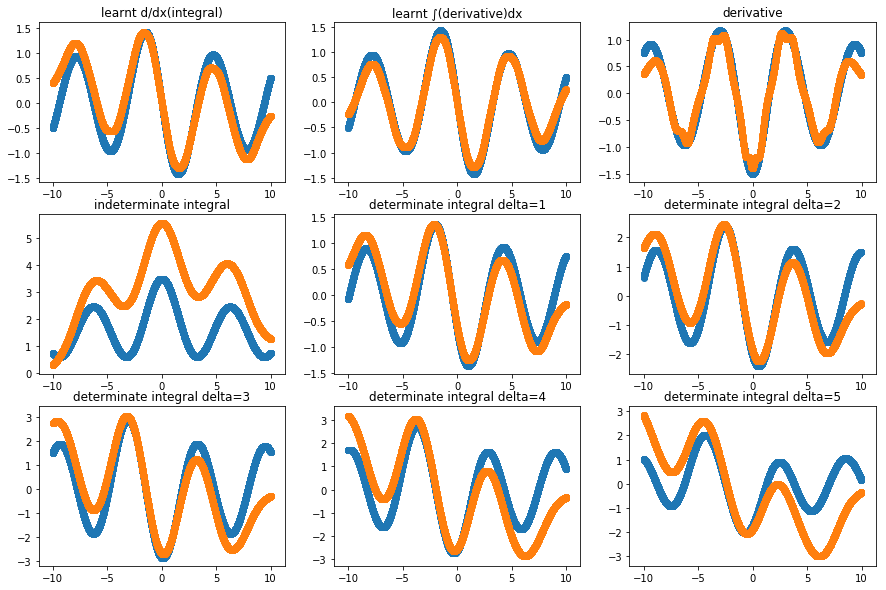

In [62]:
plt.figure(figsize=(15,10))
plt.subplot(3,3,1)
plt.title('learnt d/dx(integral)')
plt.scatter(xtest[:,0], ytest[:,0])
plt.scatter(xtest[:,0], M_DIntegral.predict(xtest)[:,0])
plt.subplot(3,3,2)
plt.title('learnt ∫(derivative)dx')
plt.scatter(xtest[:,0], ytest[:,0])
plt.scatter(xtest[:,0], M_IDerivative.predict(xtest)[:,0])
plt.subplot(3,3,3)
plt.title('derivative')
plt.scatter(xtest[:,0], lambda_dF(xtest[:,0]))
plt.scatter(xtest[:,0], M_Derivative.predict(xtest)[:,0])
plt.subplot(3,3,4)
plt.title('indeterminate integral')
plt.scatter(xtest[:,0], lambda_iF(xtest[:,0]))
plt.scatter(xtest[:,0], M_Integral.predict(xtest)[:,0])
for i in range(5):
    D = i+1
    plt.subplot(3,3,i+5)
    plt.title(f'determinate integral delta={D}')
    plt.scatter(xtest[:,0], lambda_iF(xtest[:,0] + D) - lambda_iF(xtest[:,0]))
    plt.scatter(xtest[:,0], M_Integral.predict(xtest + D)[:,0] - M_Integral.predict(xtest)[:,0])
plt.show()